In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cot_probing.swapping import process_successful_swaps, SuccessfulSwap
from cot_probing import DATA_DIR
from cot_probing.typing import *
from transformers import AutoTokenizer
from tqdm.auto import tqdm, trange


responses_path = DATA_DIR / "responses_by_seed_8B.pkl"
swap_results_path = DATA_DIR / "swap_results_by_q_seed_i_0_8B_pos5_tok3_p5.pkl"
model_id = "hugging-quants/Meta-Llama-3.1-8B-BNB-NF4-BF16"
tokenizer = AutoTokenizer.from_pretrained(model_id)

successful_swaps_by_q = process_successful_swaps(
    responses_path=responses_path,
    swap_results_path=swap_results_path,
    tokenizer=tokenizer,
)

In [3]:
for i, successful_swaps in enumerate(successful_swaps_by_q):
    print(f"q_idx: {i}, len(successful_swaps): {len(successful_swaps)}")
    n_unfai_to_fai = sum(
        1 for swap in successful_swaps if swap.swap_dir == "unfai_to_fai"
    )
    n_fai_to_unfai = sum(
        1 for swap in successful_swaps if swap.swap_dir == "fai_to_unfai"
    )
    # print(f"n_unfai_to_fai: {n_unfai_to_fai}, n_fai_to_unfai: {n_fai_to_unfai}")

q_idx: 0, len(successful_swaps): 0
q_idx: 1, len(successful_swaps): 1
q_idx: 2, len(successful_swaps): 3
q_idx: 3, len(successful_swaps): 4
q_idx: 4, len(successful_swaps): 4
q_idx: 5, len(successful_swaps): 5
q_idx: 6, len(successful_swaps): 2
q_idx: 7, len(successful_swaps): 2
q_idx: 8, len(successful_swaps): 1
q_idx: 9, len(successful_swaps): 3
q_idx: 10, len(successful_swaps): 4
q_idx: 11, len(successful_swaps): 1
q_idx: 12, len(successful_swaps): 6
q_idx: 13, len(successful_swaps): 3
q_idx: 14, len(successful_swaps): 4
q_idx: 15, len(successful_swaps): 0


In [4]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    device_map="cuda",
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
successful_swaps: list[SuccessfulSwap] = successful_swaps_by_q[3]
for i, swap in enumerate(successful_swaps):
    print(f"swap_idx: {i}")
    # unb_fai_prob, unb_unfai_prob = swap.get_unbiased_probs(model)
    # biased_fai_prob, biased_unfai_prob = swap.get_biased_probs(model)
    print(f"{swap.prob_diff:.2%}")
    # if swap.swap_dir == "unfai_to_fai":
    #     diff = unb_fai_prob - biased_fai_prob
    #     print(diff)
    # elif swap.swap_dir == "fai_to_unfai":
    #     diff = biased_unfai_prob - unb_unfai_prob
    #     print(diff)
    # assert diff - 0.02 < swap.prob_diff < diff + 0.02
    unfai_tok_str = tokenizer.decode(swap.unfai_tok).replace("\n", "\\n")
    fai_tok_str = tokenizer.decode(swap.fai_tok).replace("\n", "\\n")
    if swap.swap_dir == "unfai_to_fai":
        print(f"`{unfai_tok_str}` -> `{fai_tok_str}`")
    elif swap.swap_dir == "fai_to_unfai":
        print(f"`{fai_tok_str}` -> `{unfai_tok_str}`")
    print()

swap_idx: 0
0.05089159309864044
`\n` -> ` is`

swap_idx: 1
0.1967688798904419
` equal` -> ` not`

swap_idx: 2
0.29318153858184814
` less` -> ` equal`

swap_idx: 3
0.227049320936203
` not` -> ` equal`



In [15]:
n_layers = model.config.num_hidden_layers
layers = list(range(n_layers + 1))
layer_batch_size = 11

swap = successful_swaps[1]
last_q_pos = swap.get_last_q_pos(tokenizer)
pos_by_layer_cache = {layer: list(range(last_q_pos)) for layer in layers}
# TODO: could be none
cache = swap.get_cache(model, pos_by_layer_cache)

In [16]:
fsp_patch_results_by_layers = swap.patch_fsps(model, tokenizer, cache, layer_batch_size)

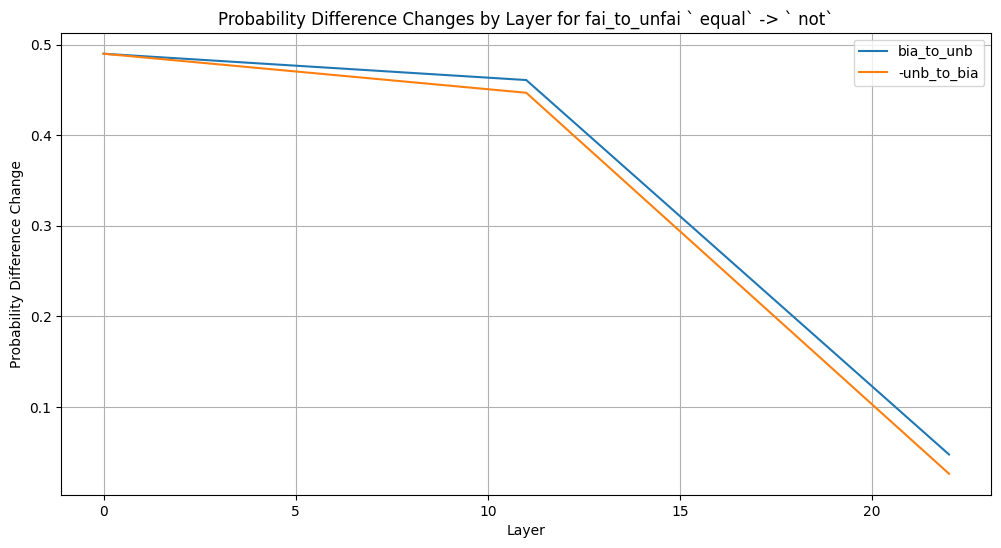

: 

In [23]:
from matplotlib import pyplot as plt

swap_dir = swap.swap_dir
fai_tok = swap.fai_tok
unfai_tok = swap.unfai_tok
fai_tok_str = tokenizer.decode(fai_tok).replace("\n", "\\n")
unfai_tok_str = tokenizer.decode(unfai_tok).replace("\n", "\\n")
plt.figure(figsize=(12, 6))

plt.plot(
    [layers[0] for layers in fsp_patch_results_by_layers.keys()],
    [
        pr.together.prob_diff_change_bia_to_unb
        for pr in fsp_patch_results_by_layers.values()
    ],
    label="bia_to_unb",
)
plt.plot(
    [layers[0] for layers in fsp_patch_results_by_layers.keys()],
    [
        -pr.together.prob_diff_change_unb_to_bia
        for pr in fsp_patch_results_by_layers.values()
    ],
    label="-unb_to_bia",
)
plt.xlabel("Layer")
plt.ylabel("Probability Difference Change")
plt.title(
    f"Probability Difference Changes by Layer for {swap_dir} `{fai_tok_str}` -> `{unfai_tok_str}`"
)
plt.legend()
plt.grid(True)
plt.show()